In [2]:
import numpy as np
import pandas as pd

In [1]:
!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"
import tensorflow as tf
import tensorflow_text as text

In [4]:
import tensorflow_hub as hub

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/spam.csv', encoding = "ISO-8859-1")
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1666,ham,Guess who spent all last night phasing in and ...,NaN,NaN,NaN
3023,ham,I love ya too but try and budget your money be...,NaN,NaN,NaN
3380,spam,"complimentary 4 STAR Ibiza Holiday or å£10,000...",NaN,NaN,NaN
4381,ham,yeah sure thing mate haunt got all my stuff so...,NaN,NaN,NaN
2616,ham,I went to ur hon lab but no one is there.,NaN,NaN,NaN


In [46]:
df.shape

(5572, 5)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [47]:
df_spam = df[df['v1']=='spam']
df_spam.shape

(747, 5)

In [48]:
df_ham = df[df['v1']=='ham']
df_ham.shape

(4825, 5)

In [49]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 5)

In [50]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 5)

In [51]:
df_balanced['v1'].value_counts()

v1
ham     747
spam    747
Name: count, dtype: int64

In [52]:
df_balanced['spam']=df_balanced['v1'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,spam
2094,spam,PRIVATE! Your 2004 Account Statement for 07742...,NaN,NaN,NaN,1
4913,ham,You've already got a flaky parent. It'snot sup...,NaN,NaN,NaN,0
4832,spam,"New Mobiles from 2004, MUST GO! Txt: NOKIA to ...",NaN,NaN,NaN,1
2707,spam,Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...,NaN,NaN,NaN,1
5041,spam,Jamster! To get your free wallpaper text HEART...,NaN,NaN,NaN,1


In [54]:
import matplotlib.pyplot as plt

In [51]:
!pip install wordcloud

In [57]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

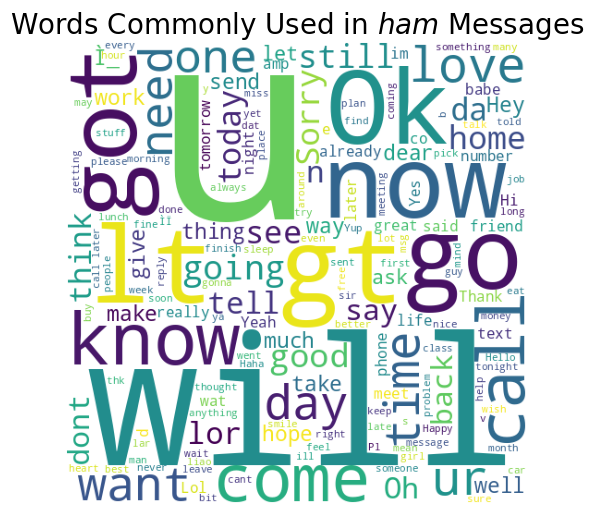

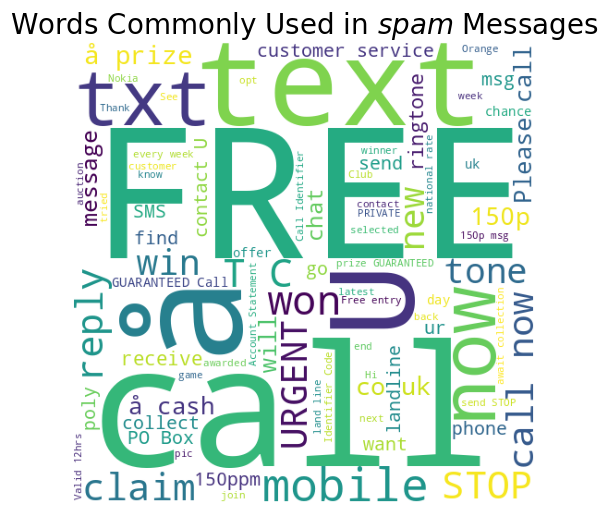

In [58]:
for v1, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = df.query("v1 == @v1")["v2"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${v1}$ Messages", size=20)
    plt.show()

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['v2'],df_balanced['spam'], stratify=df_balanced['spam'])

In [60]:

X_train.head(5)

1459    Bought one ringtone and now getting texts cost...
1088    You are awarded a SiPix Digital Camera! call 0...
2435                           Oh ya ya. I remember da. .
5482    URGENT We are trying to contact you Last weeke...
4086    PRIVATE! Your 2003 Account Statement for 07973...
Name: v2, dtype: object

In [5]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [37]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])


In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [39]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [63]:
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 598s 17s/step - loss: 0.4149 - accuracy: 0.8652 - precision: 0.8484 - recall: 0.8893


In [64]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [65]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,

In [66]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[166,  21],
       [ 17, 170]])

Text(50.722222222222214, 0.5, 'Truth')

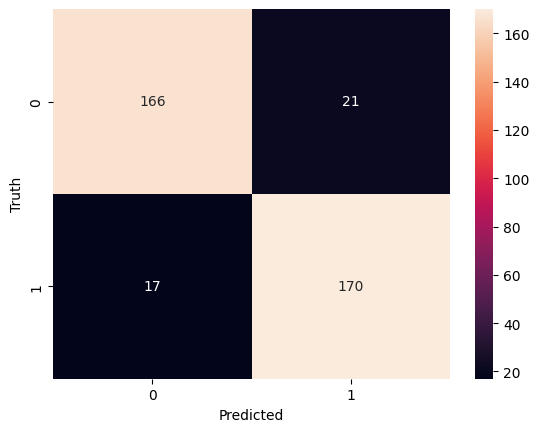

In [67]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [68]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       187
           1       0.89      0.91      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [70]:


rev = [
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'Life sucks but you can make it beautiful',
    'Congrats,You won $1000 now give this money to poor people',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
result = model.predict(rev)

print(np.round(result))

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]]
